<a href="https://colab.research.google.com/github/Aditya-Poli/Fake-news-detection/blob/dev/dl_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing necessary libraries and data

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
import tensorflow as tf 
import re
import nltk
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
import seaborn as sns 
plt.style.use('ggplot')

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Data Processing

## Data Cleaning

In [3]:
fake = f"/content/drive/MyDrive/EC3M2/fake-and-real-news-dataset/Fake.csv"
true = f"/content/drive/MyDrive/EC3M2/fake-and-real-news-dataset/True.csv"

In [4]:
df = pd.read_csv(fake)
df['label'] = 0
df1 = pd.read_csv(true)
df1['label'] = 1
df = pd.concat([df, df1])
df.head(5)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [5]:
df.tail(5)

,title,text,subject,date,label
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 21416
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


In [7]:
X, y = df['title'], df['label']
X_text, y_text = df['text'], df['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=35)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=35)

In [9]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size=0.4, random_state=35)
X_text_val, X_text_test, y_text_val, y_text_test = train_test_split(X_text_test, y_text_test, test_size=0.5, random_state=35)

## Normalizing our data: lower case, get rid of extra spaces, and url links. 

In [10]:
def normalize(data):
    normalized = []
    for i in data:
        i = i.lower()
        # get rid of urls
        i = re.sub('https?://\S+|www\.\S+', '', i)
        # get rid of non words and extra spaces
        i = re.sub('\\W', ' ', i)
        i = re.sub('\n', '', i)
        i = re.sub(' +', ' ', i)
        i = re.sub('^ ', '', i)
        i = re.sub(' $', '', i)
        normalized.append(i)
    return normalized

X_train = normalize(X_train)
X_test = normalize(X_test)

In [11]:
max_vocab = 10000
tokenizer = Tokenizer(num_words=max_vocab)
tokenizer.fit_on_texts(X_train)

## Convert text to vectors, our classifier only takes numerical data. 

In [12]:
# tokenize the text into vectors 
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [13]:
X_val = tokenizer.texts_to_sequences(X_val)

## Apply padding so we have the same length for each article 

In [14]:
sent_length= 256

In [15]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, padding='post', maxlen=sent_length)
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, padding='post', maxlen=sent_length)
X_val = tf.keras.preprocessing.sequence.pad_sequences(X_val, padding='post', maxlen=sent_length)

# Building the RNN.

In [28]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0])
except:
    pass

In [21]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [22]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_vocab, 32,input_length=sent_length),
    tf.keras.layers.SimpleRNN(64, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.SimpleRNN(16),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 256, 32)           320000    
                                                                 
 simple_rnn_14 (SimpleRNN)   (None, 256, 64)           6208      
                                                                 
 dropout_13 (Dropout)        (None, 256, 64)           0         
                                                                 
 simple_rnn_15 (SimpleRNN)   (None, 16)                1296      
                                                                 
 dense_14 (Dense)            (None, 64)                1088      
                                                                 
 dropout_14 (Dropout)        (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 1)                

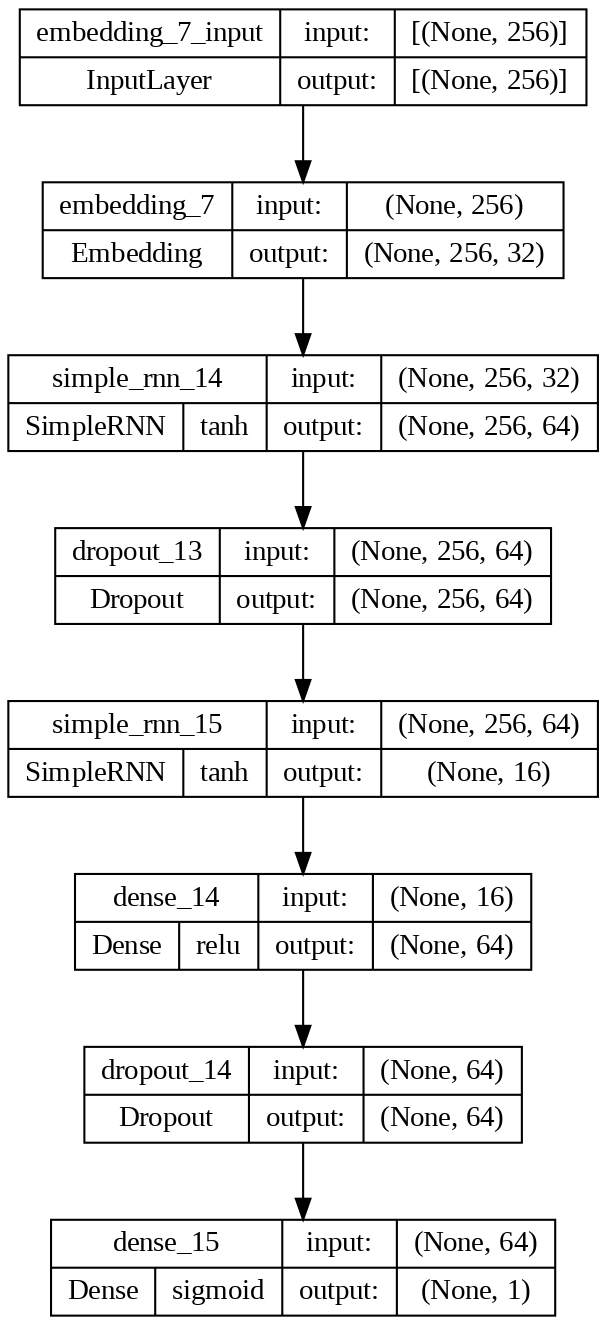

In [63]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file="/content/drive/MyDrive/EC3M2/out/artifacts/RNN.png", show_shapes=True, dpi=150, show_layer_activations=True)

**We are going to use early stop, which stops when the validation loss no longer improve.**

In [41]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
            optimizer=tf.keras.optimizers.Adam(1e-4),
            metrics=['accuracy'])

In [42]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=30, shuffle=True, callbacks=[early_stop])

Epoch 1/10
898/898 [==============================] - 143s 156ms/step - loss: 0.4812 - accuracy: 0.7630 - val_loss: 0.3208 - val_accuracy: 0.8762
Epoch 2/10
898/898 [==============================] - 139s 155ms/step - loss: 0.2414 - accuracy: 0.9198 - val_loss: 0.2977 - val_accuracy: 0.8944
Epoch 3/10
898/898 [==============================] - 141s 157ms/step - loss: 0.1759 - accuracy: 0.9452 - val_loss: 0.2783 - val_accuracy: 0.9096
Epoch 4/10
898/898 [==============================] - 139s 154ms/step - loss: 0.1423 - accuracy: 0.9564 - val_loss: 0.2364 - val_accuracy: 0.9262
Epoch 5/10
898/898 [==============================] - 142s 158ms/step - loss: 0.1044 - accuracy: 0.9697 - val_loss: 0.3693 - val_accuracy: 0.8832
Epoch 6/10
898/898 [==============================] - 142s 158ms/step - loss: 0.0921 - accuracy: 0.9735 - val_loss: 0.2545 - val_accuracy: 0.9274
Epoch 7/10
898/898 [==============================] - 137s 153ms/step - loss: 0.0730 - accuracy: 0.9791 - val_loss: 0.4279 -

**Visualize our training over time**

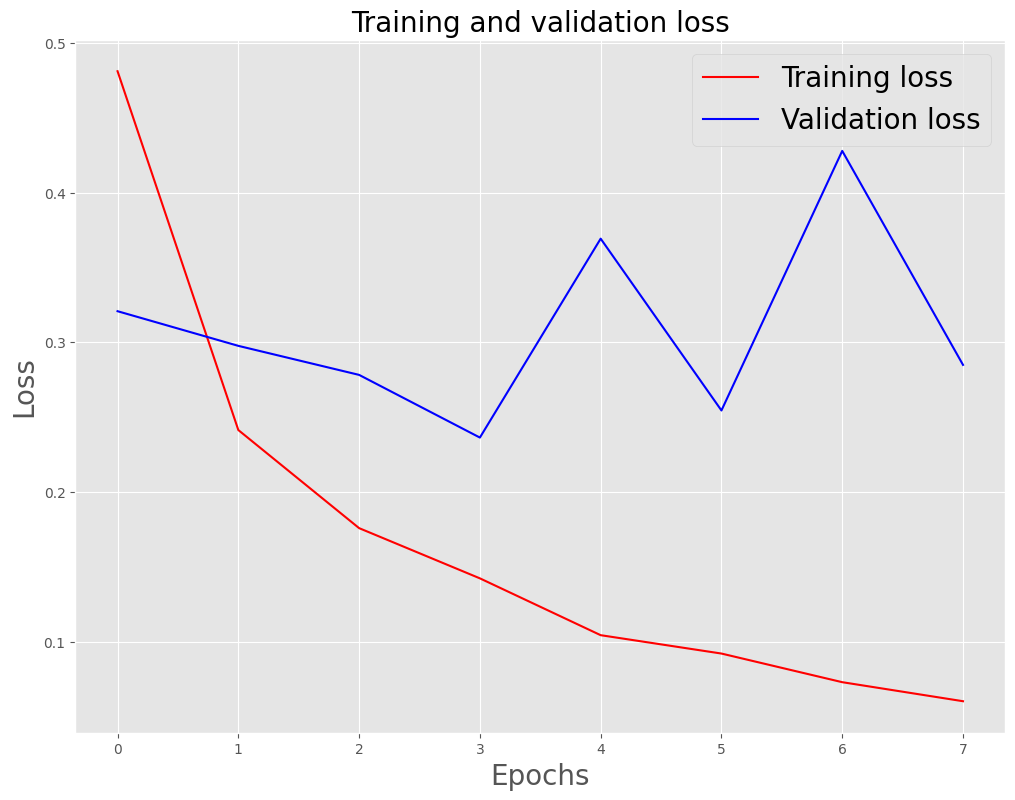

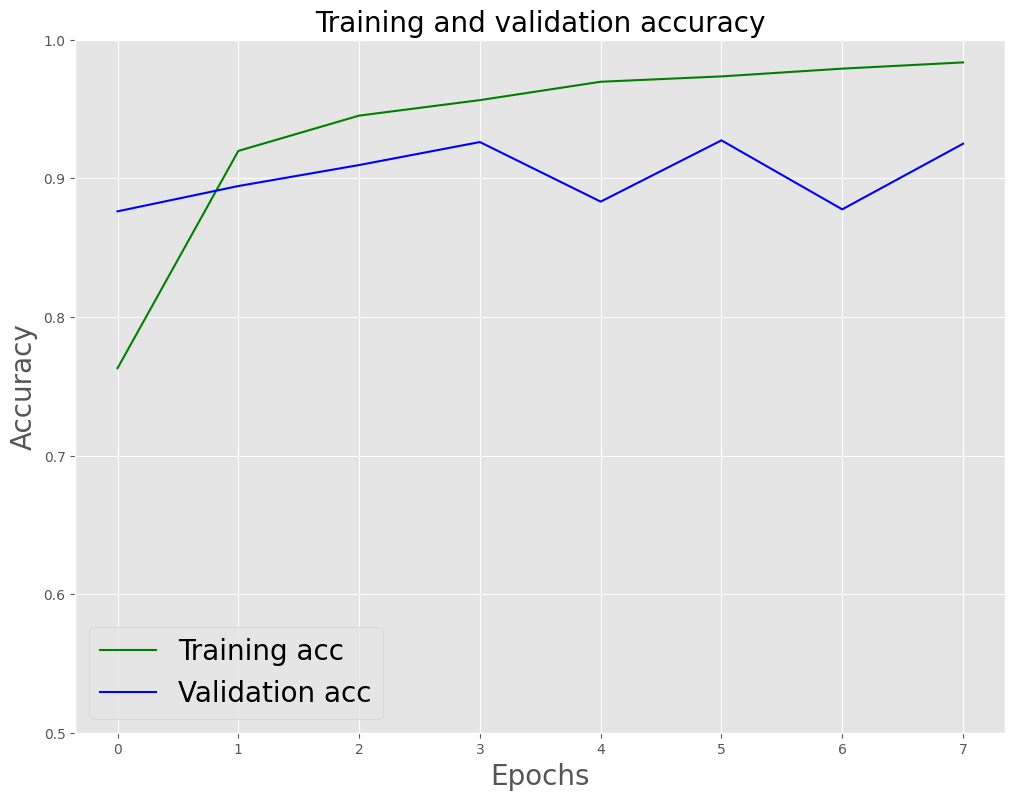

In [64]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = history.epoch

plt.figure(figsize=(12,9))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Loss', size=20)
plt.legend(prop={'size': 20})
plt.savefig('/content/drive/MyDrive/EC3M2/out/artifacts/tvl.jpg', dpi=150)
plt.show()

plt.figure(figsize=(12,9))
plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy', size=20)
plt.xlabel('Epochs', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(prop={'size': 20})
plt.ylim((0.5,1))
plt.savefig('/content/drive/MyDrive/EC3M2/out/artifacts/tva.jpg', dpi=150)
plt.show()

**Evaluate the testing set**

In [44]:
model.evaluate(X_test, y_test)

281/281 [==============================] - 10s 37ms/step - loss: 0.2152 - accuracy: 0.9372


[0.21518436074256897, 0.937193751335144]

In [62]:
import pickle
pickle.dump(model, open('/content/drive/MyDrive/EC3M2/out/models/RNN.sav','wb'))

In [45]:
pred = model.predict(X_test)

binary_predictions = []

for i in pred:
    if i >= 0.5:
        binary_predictions.append(1)
    else:
        binary_predictions.append(0) 

281/281 [==============================] - 10s 36ms/step


In [48]:
print('Accuracy on testing set:', accuracy_score(binary_predictions, y_test))
print('Precision on testing set:', precision_score(binary_predictions, y_test))
print('Recall on testing set:', recall_score(binary_predictions, y_test))

Accuracy on testing set: 0.9371937639198218
Precision on testing set: 0.9434410646387833
Recall on testing set: 0.9241154562383612


**Confusion matrix**

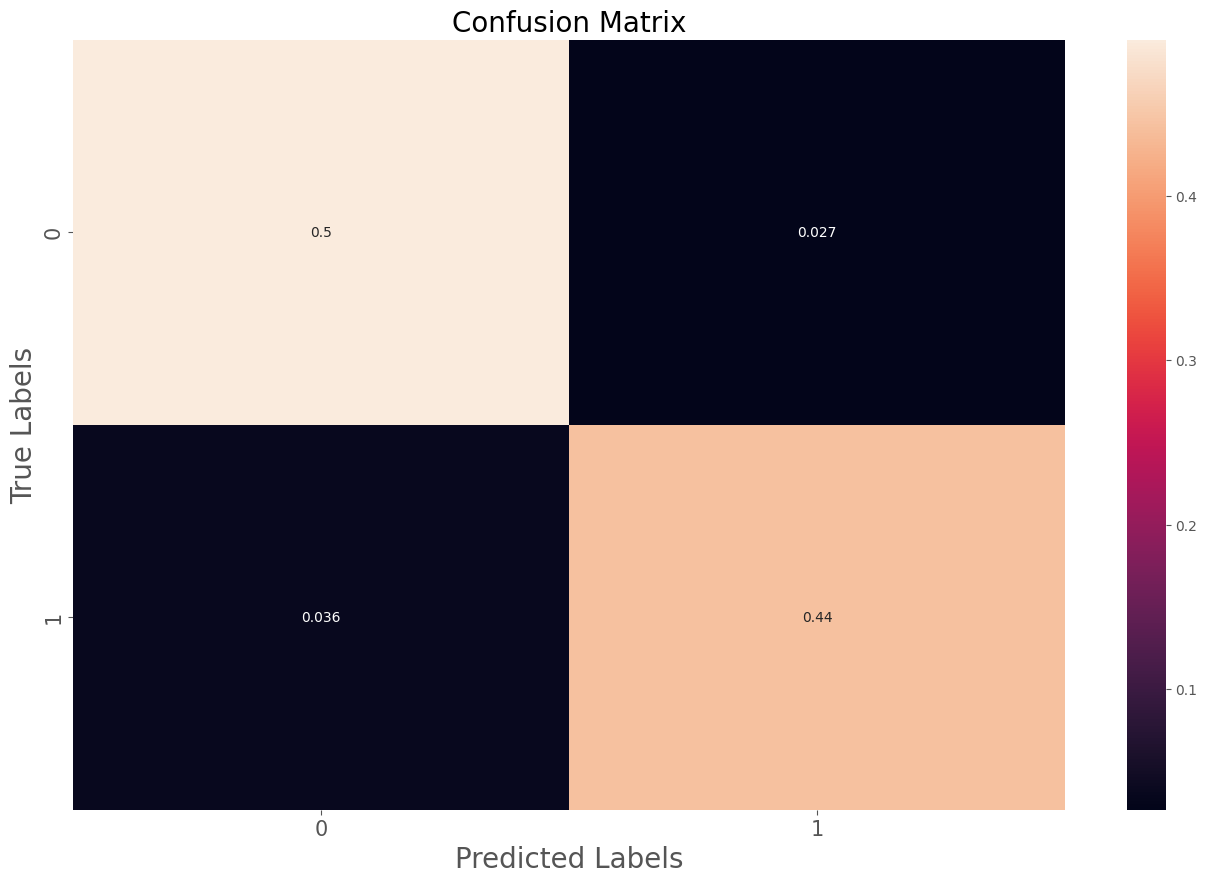

In [65]:
matrix = confusion_matrix(binary_predictions, y_test, normalize='all')
plt.figure(figsize=(16, 10))
ax= plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax)

# labels, title and ticks
ax.set_xlabel('Predicted Labels', size=20)
ax.set_ylabel('True Labels', size=20)
ax.set_title('Confusion Matrix', size=20) 
ax.xaxis.set_ticklabels([0,1], size=15)
ax.yaxis.set_ticklabels([0,1], size=15)
plt.savefig('/content/drive/MyDrive/EC3M2/out/artifacts/cm/RNN.jpg', dpi=150)

**Saves the weights for visualiation**

In [50]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

(10000, 32)


In [51]:
word_index = list(tokenizer.word_index.keys())
word_index = word_index[:max_vocab-1]

In [53]:
from sklearn.metrics import classification_report
print(classification_report(y_test, binary_predictions))

              precision    recall  f1-score   support

           0       0.95      0.93      0.94      4772
           1       0.92      0.94      0.93      4208

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980

